In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
import glob
from knr import RandomSearchKNNR,mape
from sklearn.metrics import (max_error,mean_absolute_error,mean_squared_log_error,mean_squared_error,
                             r2_score,explained_variance_score)
import seaborn as sns

In [26]:
#nombres ={'M01':'La_Rumorosa','M02':'Merida','M03':'Ciudad_Cuahutemoc',
#         'M04':'CERTE','M05':'Ojuelos','M06':'San_Fernando','M07':'Tepexi'}

In [28]:
#for base,name in nombres.items():
#    l=glob.glob(f"data/raw/{base}*.txt")
#    l.sort()
#    tdf=pd.DataFrame()
#    skr=[]
#    print(base)
#    for i,fn in enumerate(l):
#        if i>0:
#            skr=[1,2]
#        else:
#            skr=[]
#        df=pd.read_csv(fn,sep=' ', skiprows=skr)
#        if i==0: 
#            df['Fecha']=['NA','NA']+[f"{int(Y)}-{str(int(M)).zfill(2)}-{str(int(D)).zfill(2)} {str(int(h)).zfill(2)}:{str(int(m)).zfill(2)}:00" for
#                        Y,M,D,h,m in df[['YYYY','MM','DD','hh','mm']].values[2:]]
#        else:
#            df['Fecha']=[f"{int(Y)}-{str(int(M)).zfill(2)}-{str(int(D)).zfill(2)} {str(int(h)).zfill(2)}:{str(int(m)).zfill(2)}:00" for
#                        Y,M,D,h,m in df[['YYYY','MM','DD','hh','mm']].values]
#        tdf=pd.concat((tdf,df))
#    tdf.to_csv(f"{base}_{name}.csv.zip", index=None)

# Descripción de los datos

La fuente de los datos es: http://aems.ineel.mx/

Los archivos están en formato csv comprimidos para ahorrar espacio. De las primeras tres filas: La primera fila contiene el nombre de cada variable; la segunda, la altura de medición en metros sobre el nivel del suelo y la tercera, las unidades de medida. Después de las primeras tres filas se tienen las mediciones.

Las primeras cuatro columnas contienen la fecha: YYYY (año), MM (mes), dd (día), hh (hora) y mm (minuto). Los datos de todas las estaciones están referenciados a la hora de invierno del centro del país (Ciudad de México UTC-06:00). Se agregaron las columnas date con la fecha en formato "YYYY-MM-dd hh:mm" para indizar y facilitar el proceso de resampleo con pandas. Adémas se incluyo la columna "Station" que con el id de la estación y el nombre de la misma.

Por cada altura de medición, los campos de las variables se repiten cuatro veces para los valores estadísticos de media, máxima, mínima y desviación estándar.

Los nombres de las variables tienen la forma “Variable_Altura_Estadística”, donde WS (velocidad del viento), WD (dirección del viento), temp (temperatura de aire), RH (humedad relativa), P (presión barométrica), Rad (radiación solar), DENSIDAD (densidad del aire).

Los archivos son:
- data/M01_La_Rumorosa.csv.zip
- data/M02_Merida.csv.zip
- data/M03_Ciudad_Cuahutemoc.csv.zip
- data/M04_CERTE.csv.zip
- data/M05_Ojuelos.csv.zip
- data/M06_San_Fernando.csv.zip
- data/M07_Tepexi.csv.zip


Leer los datos de La Rumorosa, omitimos los datos de las filas 1 y 2 para obtener solo las mediciones.

In [2]:
data=pd.read_csv('data/M01_La_Rumorosa.csv.zip', skiprows=[1,2]) #
data['Fecha']=pd.to_datetime(data.Fecha)
data=data.set_index('Fecha')  # Especificamos que el indice es la columna Fecha
#data=pd.to_datetime(data.index)

In [3]:
len(data) # Tenemo 132648 mediciones cada 10 min de 2018-01-01 00:00:10 a 2020-08-01 00:00:00

132588

Tomamos como serie de tiempo uni-dimensional la columna para el la media de la velocidad del viento medida a 80m de altura *WS_80mA_mean*. Por velocidad solo tomaremos el último bimestre. Es decir de 2020-06-01 00:00:00 a 2020-07-29 23:50:00 y predeciremos los días 30 y 31 del mes 7 

In [95]:
y=data['2020-06-01 00:00:00':'2020-07-29 23:50:00'].WS_80mA_mean # Train
yr=data['2020-07-30 00:00:00':].WS_80mA_mean # Datos reales

<AxesSubplot:xlabel='Fecha'>

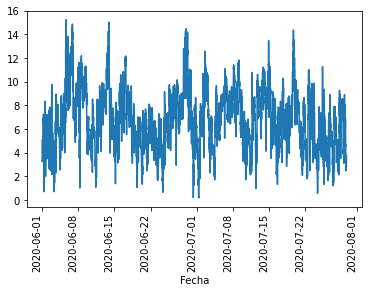

In [96]:
y.plot(rot=90) # La serie de tiempo del entranamiento

In [97]:
len(yr) # vamos a predecir 289 valores hacia el futuro

289

In [98]:
knr=RandomSearchKNNR(y, prediction_size=len(yr)) # Optimizar un clasificador KNN para n-step ahead
knr.fit()

iteration: 1, fitness: 0.44265960691083406, best fitness: 0.44265960691083406
iteration: 11, fitness: 0.4243250897608509, best fitness: 0.3461380653355033
iteration: 21, fitness: 0.44881169894441236, best fitness: 0.31773992059521794
iteration: 31, fitness: 0.4727172126652185, best fitness: 0.31773992059521794
iteration: 41, fitness: 0.42570337289718607, best fitness: 0.31773992059521794
iteration: 51, fitness: 0.43685685961396353, best fitness: 0.31773992059521794
iteration: 61, fitness: 0.34386859015215737, best fitness: 0.31773992059521794


In [111]:
yp=knr.predict() #Predecir

In [100]:
knr.conf

(82, 30, 9, 'minkowski', 'distance')

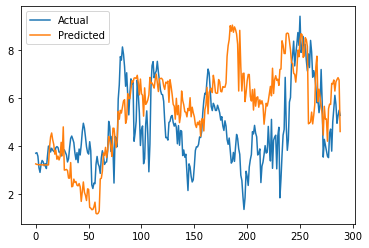

In [112]:
#Predicción a intervalos de diez minutos
plt.plot(yr.values)
plt.plot(yp)
plt.legend(['Actual','Predicted']) 

In [102]:
print("MAPE:", mape(yr,yp)) # 
print("MSE:", mean_squared_error(yr,yp)) 

MAPE: 0.4182780338179307
MSE: 4.1955383592392606


In [103]:
ys=y.resample('0.5H').mean() # resampleo cada media hora
yrs=yr.resample('0.5H').mean()
len(yrs) # Ahora solo vamos a predecir 97 valores

97

In [104]:
knr1=RandomSearchKNNR(ys, prediction_size=len(yrs)) # Optimizar un clasificador KNN
knr1.fit()

iteration: 1, fitness: 0.2998885239672336, best fitness: 0.2998885239672336
iteration: 11, fitness: 0.4223741072923492, best fitness: 0.2998885239672336
iteration: 21, fitness: 0.3237112851338175, best fitness: 0.2998885239672336
iteration: 31, fitness: 0.4454274895555298, best fitness: 0.2998885239672336
iteration: 41, fitness: 0.37517685453116645, best fitness: 0.2998885239672336
iteration: 51, fitness: 0.4372770027399747, best fitness: 0.2998885239672336
iteration: 61, fitness: 0.4167597856602111, best fitness: 0.2998885239672336


In [105]:
knr1.conf

(40, 20, 10, 'minkowski', 'distance')

In [106]:
yps=knr1.predict()

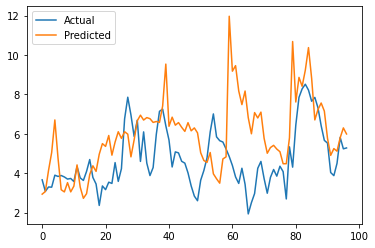

In [113]:
plt.plot(yrs.values)
plt.plot(yps)
plt.legend(['Actual','Predicted']) 

In [86]:
print("MAPE:", mape(yrs,yps)) # 
print("MSE:", mean_squared_error(yrs,yps)) 

MAPE: 0.4209338412035008
MSE: 3.6337802170711213
